In [41]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split, RandomizedSearchCV, KFold
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import accuracy_score, classification_report, mean_squared_error
import warnings
warnings.filterwarnings('ignore')

from xgboost import XGBRegressor
import xgboost as xgb
from scipy.stats import uniform, randint
import matplotlib.pyplot as plt
import seaborn as sns

In [42]:
df = pd.read_csv("klar_for_oppgave_5.csv",index_col=0)
X = df.drop(columns=["Close"])
y = df["Close"]

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [43]:
X_train.head()

,PLS_Component_1,PLS_Component_2,PLS_Component_3,PLS_Component_4,PLS_Component_5,PLS_Component_8,PLS_Component_9,PLS_Component_10,PLS_Component_12
2323,4.889292,-2.977292,1.944830,-0.947995,-0.026429,0.597677,-0.545085,-0.565256,0.383897
1042,-6.348190,4.731218,-1.824143,0.622389,-0.160912,-0.335043,0.348016,0.202034,-0.181195
2820,7.246649,-4.794195,2.807452,-0.870533,0.757662,0.276345,-0.406990,-0.128273,0.001728
2759,6.128037,-4.198443,2.182937,-0.700179,0.606949,0.163217,-0.264682,-0.106247,-0.096071
1100,-5.479450,3.571300,-2.226312,0.666937,-0.549482,-0.369109,0.372466,0.223085,-0.207036


In [44]:
y_train.head()

2323    0.640
1042    0.140
2820    0.760
2759    0.725
1100    0.170
Name: Close, dtype: float64

In [45]:
# Define the XGBoost regressor
xgb_model = XGBRegressor(eval_metric='rmse')

# Define the parameter grid for RandomizedSearchCV
param_dist = {
    'learning_rate': uniform(0.01, 0.3),
    'n_estimators': randint(100, 1000),
    'max_depth': randint(3, 10),
    'min_child_weight': randint(1, 10),
    'subsample': uniform(0.5, 0.5),
    'colsample_bytree': uniform(0.5, 0.5),
    'gamma': uniform(0, 0.5)
}

# Set up the RandomizedSearchCV with 5-fold cross-validation
random_search = RandomizedSearchCV(
    estimator=xgb_model, 
    param_distributions=param_dist, 
    n_iter=100, 
    cv=5, 
    verbose=1, 
    random_state=42, 
    n_jobs=-1
)

# Fit the model
random_search.fit(X_train, y_train)

# Output the best hyperparameters found
print("\n*** Best hyperparameters found ***"), 
best_params = random_search.best_params_
for param, value in best_params.items():
    print(f"{param}: {value:.5f}")

# Get the best model
best_model = random_search.best_estimator_

# Make predictions
y_pred = best_model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("\nModel Evaluation:")
print(f"Mean Squared Error (MSE): {mse:.5f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.5f}")
print(f"Mean Absolute Error (MAE): {mae:.5f}")
print(f"R-squared (R2): {r2:.5f}")

Fitting 5 folds for each of 100 candidates, totalling 500 fits

*** Best hyperparameters found ***
colsample_bytree: 0.83175
gamma: 0.00253
learning_rate: 0.05824
max_depth: 4.00000
min_child_weight: 2.00000
n_estimators: 921.00000
subsample: 0.72421

Model Evaluation:
Mean Squared Error (MSE): 0.00018
Root Mean Squared Error (RMSE): 0.01331
Mean Absolute Error (MAE): 0.01032
R-squared (R2): 0.99643


<Figure size 1000x600 with 0 Axes>

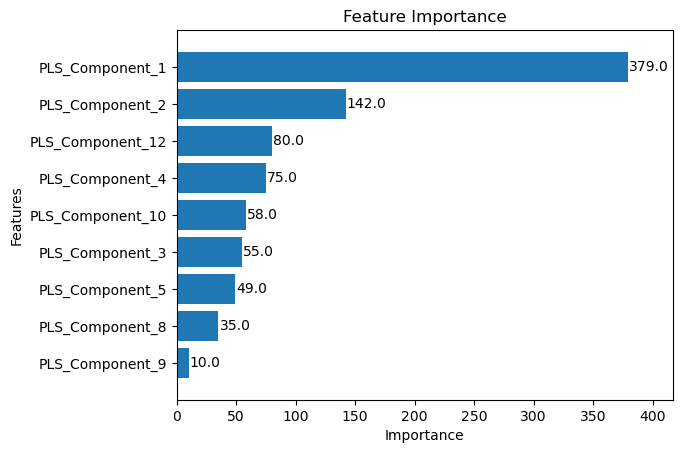

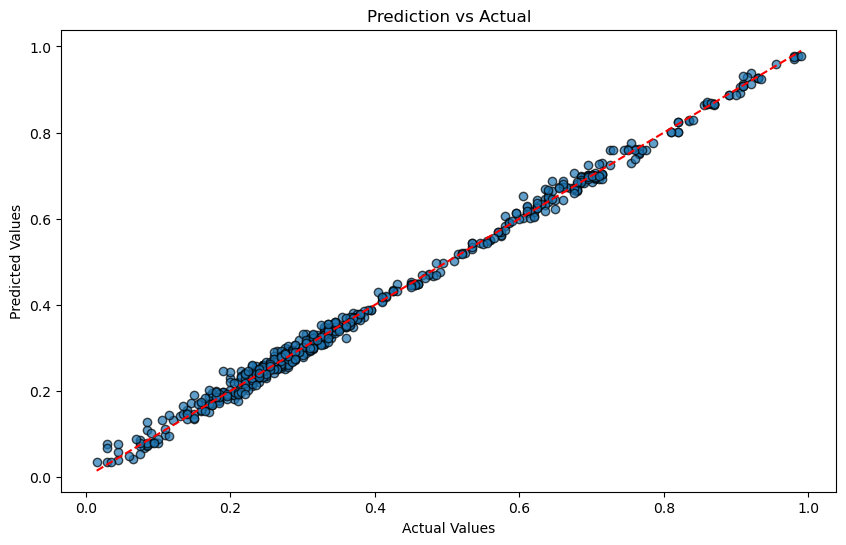

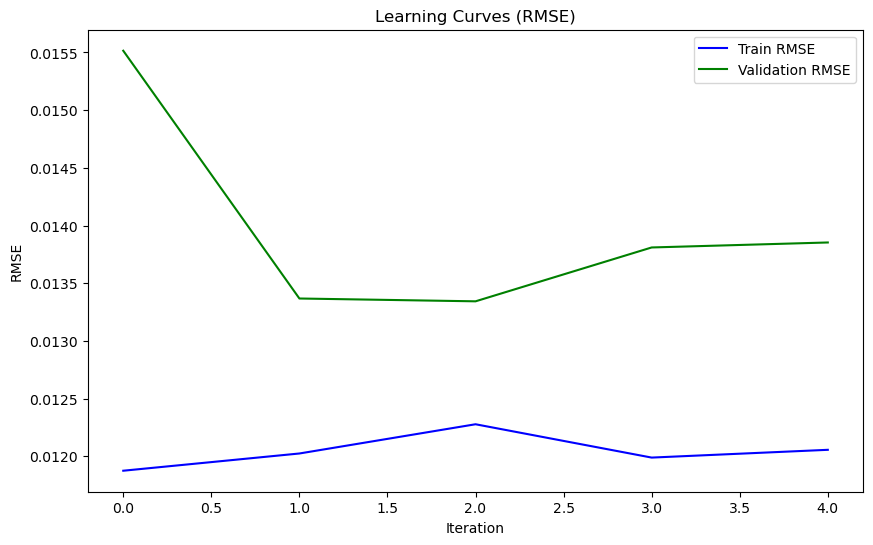

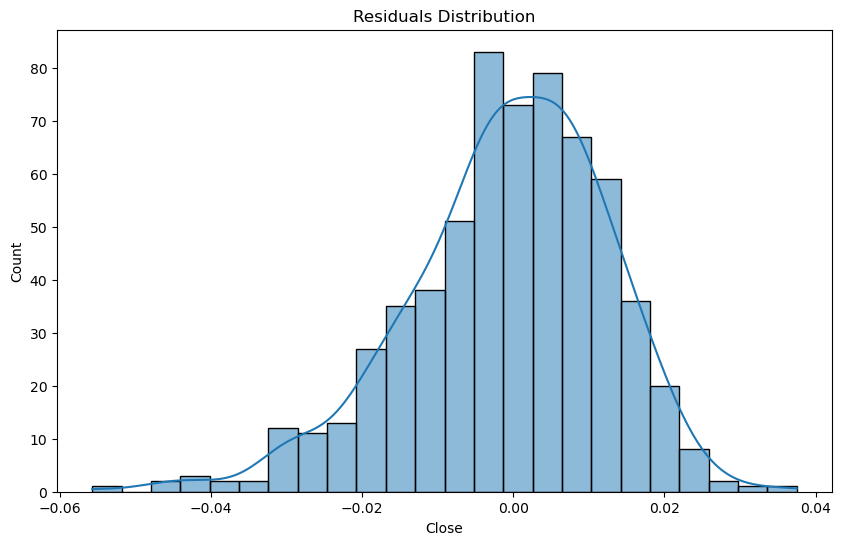

In [48]:
# Plotting Feature Importance using XGBoost's built-in method
plt.figure(figsize=(10, 6))

# Plot the feature importance using XGBoost's plot_importance method
xgb.plot_importance(best_model, 
                    importance_type='weight',  # 'weight', 'gain', or 'cover' (you can try different types)
                    max_num_features=10,      # Adjust how many top features you want to show
                    height=0.8,               # Bar height
                    title='Feature Importance', 
                    xlabel='Importance', 
                    ylabel='Features')
plt.grid(False)
plt.show()


# Set up the figure and axes for plotting
plt.figure(figsize=(10, 6))

# Plot 2: Prediction vs Actuals (scatter plot)
#plt.subplot(2, 2, 2)
plt.scatter(y_test, y_pred, alpha=0.7, edgecolors='k')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='r', linestyle='--')  # Ideal line
plt.title('Prediction vs Actual')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.show()

# Plot 3: Learning curves (Training vs Validation RMSE)
# Manually compute learning curves using KFold cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)
train_errors, val_errors = [], []

for train_index, val_index in kf.split(X_train):
    # Split data into train and validation sets
    X_train_cv, X_val_cv = X_train.iloc[train_index], X_train.iloc[val_index]
    y_train_cv, y_val_cv = y_train.iloc[train_index], y_train.iloc[val_index]
    
    # Train the model on this fold
    best_model.fit(X_train_cv, y_train_cv)
    
    # Predict on train and validation data
    train_pred = best_model.predict(X_train_cv)
    val_pred = best_model.predict(X_val_cv)
    
    # Compute the RMSE for both train and validation sets
    train_rmse = np.sqrt(mean_squared_error(y_train_cv, train_pred))
    val_rmse = np.sqrt(mean_squared_error(y_val_cv, val_pred))
    
    # Append the errors to the lists
    train_errors.append(train_rmse)
    val_errors.append(val_rmse)


# Plot RMSE learning curve
plt.figure(figsize=(10, 6))
plt.plot(train_errors, label='Train RMSE', color='b')
plt.plot(val_errors, label='Validation RMSE', color='g')
plt.title('Learning Curves (RMSE)')
plt.xlabel('Iteration')
plt.ylabel('RMSE')
plt.legend()
plt.show()


# Plot 4: Distribution of residuals (Prediction error)
residuals = y_test - y_pred
plt.figure(figsize=(10, 6))
sns.histplot(residuals, kde=True)
plt.title('Residuals Distribution')
plt.show()